In [1]:
import numpy as np
import networkx as nx
from itertools import combinations
from random import randrange
import matplotlib.pyplot as plt 
from numpy.linalg import inv
import scipy.sparse as sp
np.set_printoptions(precision=3)

In [2]:
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).toarray()

def get_sparse_eigen_decomposition(graph, K):
    adj = nx.adjacency_matrix(graph).toarray()
    normalized_adj = normalize_adj(adj)
    eigenval,eigenvectors  = np.linalg.eig(normalized_adj)
    
    eigenval_Ksparse = np.argsort(eigenval)[-K:]
    V_ksparse = np.zeros(adj.shape)
    V_ksparse[:,eigenval_Ksparse] = eigenvectors[:,eigenval_Ksparse]
    
    V_ksparse = np.matrix(V_ksparse)
    V_ksparse_H = V_ksparse.getH()
    
    return V_ksparse, V_ksparse_H

def plot_graph(graph):
    nx.draw_shell(graph,with_labels=True,)
    
def get_random_undirected_graph(N):
    random_undirected_graph=nx.Graph()
    for node_pair in combinations(range(N), 2):
        if randrange(5) == 1:
             random_undirected_graph.add_edge(node_pair[0],node_pair[1])
    return random_undirected_graph

def get_H(num_nodes):
    H =  np.matrix(np.identity(num_nodes))
    H_h = H.getH()
    return H, H_h

def get_W(VH, H_h, H, V):
    a = np.matmul(VH, H_h)
    b =  np.matmul(a, H)
    W = np.matmul(b, V) 
    return W 

def get_random_signal_from_cov(cov_matrix, mean):
    return np.random.multivariate_normal(mean, cov_matrix)

def argmax(K,remaining_node):
    u = (0,-1) # score, index
    for candidate in remaining_node:
        v_u = V_ksparse_H[:,candidate]
        v_u_H = V_ksparse[candidate,:]
        a = (v_u_H * K)
        numerator = (((a * W) * K) * v_u)
        lamda_inv = 1.0 / float(cov_w[candidate][candidate]) # get lam^(-1)_w,u should always be the same
        denumerator = lamda_inv + (a * v_u)
        score = numerator/denumerator
        if score > u[0]:
            u = (score, candidate)
    return u[1]

def update_K(K, u): #Should be O(K^2)
    v_u = V_ksparse_H[:,u]
    v_u_H = V_ksparse[u,:]
    numerator = (((K * v_u) * v_u_H)* K)
    lamda_inv = 1.0 / float(cov_w[u][u]) # get lam^(-1)_w,u should always be the same
    denumerator = lamda_inv + ((v_u_H * K) * v_u)
    matrix = numerator/denumerator
    x = (W * matrix)
    return K - x

def greedy_algo():
    G_subset = []
    remaining_node = list(range(0,NUM_NODES))
    K = cov_x
    for j in l:
        u = argmax(K,remaining_node)
        K = update_K(K, u)
        G_subset.append(u)
        remaining_node.remove(u)
    return G_subset, K

def get_upper_bound_trace_K():
    upper_bound_matrix = np.matrix(W * cov_x)
    return float(upper_bound_matrix.trace())

def get_K_trace(possible_set):
    inv_cov_x = inv(cov_x)
    for i in possible_set:
        v_i = V_ksparse_H[:,i]
        v_i_H = V_ksparse[i,:]
        lamda_inv = 1.0 / float(cov_w[i][i]) 
        inv_cov_x = inv_cov_x + lamda_inv * (v_i * v_i_H)
    K = np.matrix((((H * V_ksparse) * inv(inv_cov_x)) * V_ksparse_H) * H_h)
    return float(K.trace())

def brute_force_algo():
    rank = {}
    min_set = []
    optimal_K_T = get_upper_bound_trace_K()
    all_possible_set_combination = combinations(range(NUM_NODES), number_node_sampled)
    for possible_set in all_possible_set_combination:
        score = get_K_trace(possible_set)
        rank[str(list(possible_set))] = score
        if score <= optimal_K_T:
            optimal_K_T = score
            min_set = possible_set
    return optimal_K_T, min_set, rank

In [3]:
NUM_NODES  = 20
NOISE_CONSTANT = 10e2
K_sparse = 5
MEAN = np.zeros((NUM_NODES,))
number_node_sampled = 5

In [4]:
def get_relative_suboptimality(optimal_K_T, f_K_T, empty_K_T):
    
    return (f_K_T - optimal_K_T) / (empty_K_T - optimal_K_T)

In [46]:
relative_sub_Erdos_greedy = []
relative_sub_Erdos_randomized = []
for simul in range(10):
    graph = get_random_undirected_graph(NUM_NODES)
    while(len(graph.nodes()) < NUM_NODES):
        graph = get_random_undirected_graph(NUM_NODES)
    V_ksparse, V_ksparse_H = get_sparse_eigen_decomposition(graph, K_sparse)
    H, H_h = get_H(NUM_NODES)

    cov_w = NOISE_CONSTANT * np.identity(NUM_NODES)
    cov_x = np.identity(NUM_NODES)

    x = get_random_signal_from_cov(cov_x, MEAN)
    w = get_random_signal_from_cov(cov_w, MEAN)
    y = x + w

    W = get_W(V_ksparse_H, H_h, H, V_ksparse)
    l = range(1,(number_node_sampled + 1))
    G_subset, K = greedy_algo()
    
    empty_set = get_K_trace([])
    optimal_K_T, min_set, rank = brute_force_algo()
    
    relative_sub_Erdos_greedy.append(get_relative_suboptimality(optimal_K_T, rank[str(list(sorted(G_subset)))]), empty_set)
    relative_sub_Erdos_randomized.append(get_relative_suboptimality(optimal_K_T, rank[str(list(sorted(G_subset)))]), empty_set))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


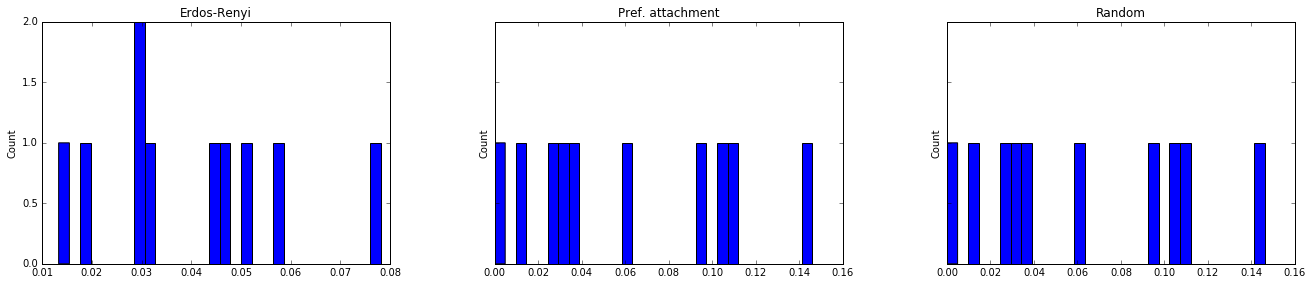

In [47]:
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib.pyplot as plt
import scipy.stats as stats

n_bins = 30
fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].set_ylabel('Count')
axs[0].hist(relative_sub_Erdos_greedy, bins=n_bins)
axs[0].set_title("Erdos-Renyi")

axs[1].set_ylabel('Count')
axs[1].hist(relative_sub, bins=n_bins)
axs[1].set_title("Pref. attachment")

axs[2].set_ylabel('Count')
axs[2].hist(relative_sub, bins=n_bins)
axs[2].set_title("Random")
fig.tight_layout()

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=3, hspace=0.5,
                     wspace=0.3)

plt.show()